## TD Simulation Individu-Centrée de la capture d'insectes dans des Pièges Barber

***
*IA RA - Angers*

*30/01/2024*
***

### Introduction

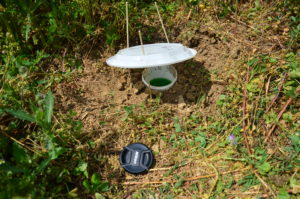

##### Import des bibliothèques utiles

In [1]:
from typing import Tuple

import numpy as np
from numpy import random
import pandas as pd
import scipy.stats
import pymc as pm
import arviz as az
import xarray as xr
import pytensor as pt
import seaborn as sns

from matplotlib import animation, rc
import matplotlib.pyplot as plt
import itertools

NB : Si ces bibliothèques ou certains modules (par exemple arviz) ne sont pas installés sur votre ordinateur, il est possible de le faire en suivant ces trois étapes :

- Ouvrir la console (Windows ou Anaconda) 
- Taper la commande *conda install arviz* dans la console Ananconda (Anaconda-Prompt) ou *pip install arviz* dans la console Windows
- Réexecuter la cellule d'import ci-dessus pour vérifier que les bibliothèques sont bien installées

In [2]:
rc('animation', html='html5')

### 1. Définitions

#### 1.1. Définition du Champ

On se place dans un champ d'un hectare (100 m par 100 m) dans lequel se déplaceront les insectes. 

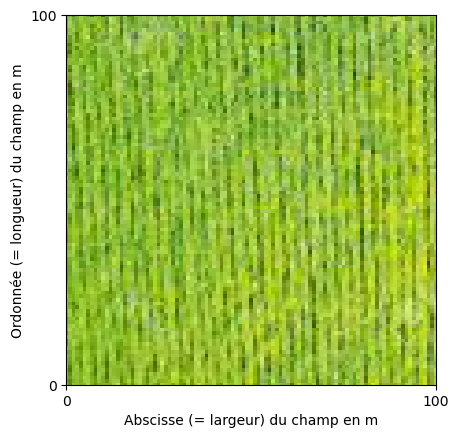

In [3]:
fig_champ = plt.figure()

ax = fig_champ.add_subplot(aspect="equal", xlim=(0, 100), ylim=(0, 100))

image = plt.imread('Champ-de-maïs20.jpg') 
ax.imshow(image)

ax.set_yticks([0, 100]) ; ax.set_xticks([0, 100])
ax.set_ylabel("Ordonnée (= longueur) du champ en m") ; ax.set_xlabel("Abscisse (= largeur) du champ en m")

plt.show()

#### 1.2. Définition des Insectes (et de leur déplacement)

##### 1.2.a. Définition des Insectes

On considère une population d'insectes qui se déplacent sur le champ. Pour plus de simplicité on considère que le déplacement des insectes est isotrope (il est equiprobable dans toutes les directions) et que la distance parcourue à chaque pas de temps est aléatoire (tirée dans une loi normale par exemple). - Ces hypothèses sont classiques dans la littérature scientifique [Ahmed et al. 2023], et constituent une approximation satisfaisante des connaissances sur les mouvements des insectes marchant, comme les carabes par exemple.

Ainsi donc, en termes plus mathématique, le déplacement des insectes à chaque pas de temps pourra être défini par un vecteur dont la direction est aléatoire, et dont la norme (qui correspond à la distance que va parcourir l'insecte) est tirée dans une loi normale.

<font color='green'> **Question 1** : A partir de la fonction *random_unit_vector()* ci-dessous qui renvoie un vecteur unité dont la direction est aléatoire, construire une fonction *random_walk_vector()* dont la direction est aléatoire et la norme tirée dans une loi normale de moyenne mu et d'écart-type sigma, représentant les capacités de dispersion d'un individu. Indice : la fonction np.random.normal(mu, sigma) renvoie une valeure tirée dans une valeure tirée dans une loi normale de moyenne mu et d'écart-type sigma  </font>

##### 1.2.b. Simulation du déplacement

Maintenant que l'on a défini les insectes et les règles regissant leur déplacement, on peut simuler leur déplacement sur plusieurs pas de temps. Dans cette section, on simule le déplacement d'un insecte sur *num_steps = 100* pas de temps. Cette simulation nous donne la suite des localisations successives occupées par l'insecte sur le champ, que l'on stocke dans une matrice de taille *2 x num_steps*.

In [4]:
num_steps = 100

def get_random_walk(num_steps, mu, sigma) :
    
    locations = np.zeros((2, num_steps))
    
    for i in range(1, num_steps):
        
        next_x, next_y = random_walk_vector(mu, sigma)
        locations[0, i] = abs(min(locations[0, i-1] + next_x, 100))
        locations[1, i] = abs(min(locations[1, i-1] + next_y, 100))
        
    return locations

#### 1.3. Définition des Pièges (et de la capture)

On a défini un champ, et des insectes qui se meuvent dessus, plaçons maitenant des pièges pour les attraper.

<font color='green'> **Question 2** : On suppose que l'on place un pot Barber au milieu du champs (sur le point de coordonnées [50,50]), et qu'il a un rayon de 0.1m. Ecrire une fonction *is_trapped()* qui prédit si l'insecte est capturé ou non en fonction de sa localisation. </font>

<font color='green'> **Question Subsidiaire** : On imagine maintenant que l'on place plusieurs pots Barber sur la parcelle. Ecrire la fonction *which_trap()* qui prédit si l'insecte est capturé et renvoie le numéro du pot Barber dans lequel il est capturé si oui et zéro sinon. </font>
    
<font color='green'> Tester la fonction pour n=3 Pots Barbers, placés sur un transect de parcelle aux coordonnées [10, 10], [10, 30] et [10, 50] numérotés 1, 2 et 3. </font>

### 2. Simulations

#### 2.1. Définition de la fonction de simulation 

On a un champ, des insectes et des pièges... Tous ce qu'il nous faut ! Il s'agit maintenant de définir une fonction de simulation c'est à dire une fonction qui prend en entrée un nombre d'insectes, de pièges (et leur positions), et un nombre de pas de temps, et qui prédit en sortie le nombre d'insectes piégé dans chaque pot Barber.

On considère ***num_inds = 10 insectes*** qui se déplacent sur le champs, pendant ***num_steps = 100 pas de temps***, selon les modalités définies plus haut dans la fonction *random_walk_vector()*. On suppose que l'on a placé ***N_Barber = 3 pots Barber*** sur un transect de la parcelle, plus précisément les points de coordonées ***location_Barber = [10, 10], [10, 30] et [10, 50]*** et qu'il ont tous le même rayon ***radius_Barber = 0,1 m***.

<font color='green'> Pas de questions ici, parce que c'est un peu fastidieux... Voici directement le code : </font>

In [5]:
def Simulate_random_walk(num_steps, 
                         num_inds, 
                         mu, sigma, 
                         N_Barber, 
                         location_Barber, radius_Barber, 
                         shortcut_mesure=False) :
    
    # On initialise un dictionnaire pour stocker le déplacement de chaque individu - Locationss - , et un dictionaire pour stocker 
    # l'instant t auquel l'individu i est piégé (s'il l'est bien entendu) et dans quel Pot_Barber (tuple (t, pot)) - dict_Trapped. 
    
    Locationss = {} ; dict_Trapped = {}
    
    for individu in range(num_inds) :
        
        # On définit au hasard une localisation initiale pour chaque individu
        locations = [[np.random.randint(0,100), np.random.randint(0,100)]]
        
        for i in range(1, num_steps):
        
            next_x, next_y = random_walk_vector(mu, sigma)
            new_location = [locations[i-1][0] + next_x, locations[i-1][1] + next_y]
            
            if bool(which_trap(new_location, N_Barber, location_Barber, radius_Barber)) :
                
                dict_Trapped[individu] = (i, which_trap(new_location, N_Barber, location_Barber, radius_Barber))
                locations[i:num_steps] = [[0,0]]*(num_steps - i + 1)
                
                break
                
            else :
            
                locations.append(new_location)
            
        Locationss[individu] = locations
    
    # Si on cherche à simuler uniquement ce que l'on peut mesurer, i.e. le nombre d'individu piégés à la fin de la simulation,
    # on peut s'arrêter rapidement ici en indiquant shortcut_mesure = True.
    
    if shortcut_mesure :
        return len(dict_Trapped)
    
    # Si des insectes on été piégés (i.e. dict_Trapped n'est pas vide), on construit une liste donnant le nombre d'individus 
    # dans le piège en fonction du temps, que l'on appelle Number_of_trapped_individuals_per_step.
        
    if bool(dict_Trapped) :
        
        Ntrapped_ind_per_step = []
        for i in range(1,N_Barber+1) :
            
            Ntrapped_ind_per_trap = [value[0] for value in dict_Trapped.values() if value[1] == i]
            Ntrapped_ind_per_step_per_trap = [sum([int(bool(k > value)) for value in Ntrapped_ind_per_trap])
                                                  for k in range(num_steps)]
            Ntrapped_ind_per_step.append(Ntrapped_ind_per_step_per_trap)
        
    return Locationss, Ntrapped_ind_per_step

#### 2.2. Implémentation et visualisation de la simulation

***Implementation***

Dans cette section on fait enfin tourner nos simultions. Pour plus de practicité, les valeurs des paramètres peuvent toutes être assignées modifiées dans la section ci-dessous :

In [6]:
num_steps = 75 ; num_inds = 100
mu = 2 ; sigma = 2
N_Barber = 3
location_Barber = [[80, 10], [80, 30], [80, 50]]
radius_Barber = 5

In [7]:
Locationss, Number_of_trapped_individuals_per_step = Simulate_random_walk(num_steps, num_inds, 
                                                                          mu, sigma, N_Barber,
                                                                          location_Barber, radius_Barber)

NameError: name 'random_walk_vector' is not defined

***Visualisation***

On affiche notre simulation grâce à la bibliothèque *animation*. Cette visualisation dynamique se code en deux temps ; D'abord on définit la figure initiale (le champs, les pièges, et les insectes dans leur position initiale), puis on définit une fonction d'animation qui modifie à chaque pas de temps la figure initiale en fonction des mouvements des insectes et de leur capture. 

Afin de suivre en direct la réussite (ou l'échec) de notre méthode de piégeage, on affiche à côté du champ un histogramme donnant le nombre d'insectes piégés dans chaque pot Barber au cours du temps. 

*Définition de la figure intiale*

In [ ]:
%%capture

fig = plt.figure(figsize = (10, 5))

# Une sous-figure pour visualiser les trajectoires des insectes

ax1 = fig.add_subplot(121, 
                       xlim = (0,100), 
                       ylim = (0,100))

ax1.scatter([location_Barber[i][0] for i in range(N_Barber)],
            [location_Barber[i][1] for i in range(N_Barber)], 
            s = 2*3.14*(radius_Barber**2), 
            c = 'white', marker = 'o', edgecolors=['gold', 'darkgreen', 'darkblue'], linewidths = 2)

previous_steps, = ax1.plot([], [], marker='o', color='darkred', linestyle='None', alpha=0.2)
current_steps, = ax1.plot([], [], marker='o', color='darkred', linestyle='None', alpha=1.0)

image = plt.imread('Champ-de-maïs20.jpg') 
ax1.imshow(image)

ax1.set_title("Simulation de la dispersion aléatoire \n de {} insectes sur la parcelle".format(num_inds))
timer_text1 = ax1.text(0.02, 0.95, "", c = "darkblue", fontstyle = 'italic', transform=ax1.transAxes)

# Une sous-figure pour visualiser l'évolution du contenu du pot Barber

ax2 = fig.add_subplot(122,
                      ylim = (0, max([max(N) for N in Number_of_trapped_individuals_per_step]) + 2))
              
ax2.set_title("Nombre d'insectes piégés \n dans les pots Barber au cours du temps")
timer_text2 = ax2.text(0.02, 0.95, "", c = "darkblue", fontstyle = 'italic', transform=ax2.transAxes)

Hist_Pot_Barber, = ax2.bar(["Pot Barber {}".format(i) for i in range(1,N_Barber+1)], 
                           [0]*N_Barber, 
                           color = ['gold', 'darkgreen', 'darkblue']),

*Définition de la fonction de rafraichissement de la figure à chaque pas de temps*

In [ ]:
def update_plot(step_num):
    
    previous_locs = []
    for i in range(num_inds) :
        previous_locs = previous_locs + Locationss[i][max(0,step_num-5):step_num]
        
    current_locs = [Locationss[i][step_num] for i in range(num_inds)]
    
    previous_steps.set_data([previous_locs[i][0] for i in range(len(previous_locs))],
                            [previous_locs[i][1] for i in range(len(previous_locs))])
    current_steps.set_data([current_locs[i][0] for i in range(len(current_locs))],
                           [current_locs[i][1] for i in range(len(current_locs))])
    
    for i in range(N_Barber) :
        Hist_Pot_Barber[i].set_height(Number_of_trapped_individuals_per_step[i][step_num])
    
    timer_text1.set_text("time = {}".format(step_num))
    timer_text2.set_text("time = {}".format(step_num))
        
    return previous_steps, current_steps, Hist_Pot_Barber, timer_text1, timer_text2

*Lancement de l'animation*

In [ ]:
Random_walk = animation.FuncAnimation(
    fig,
    update_plot,
    num_steps,
    interval=500,
)

Random_walk

Notre simulateur permet d'investiguer un grand nombre de questions de recherche (Par exemple sur la disposition des pièges [Ahmed et al. 2023], les capacités de dispersion des insectes, voire l'hétérogéinité de la parcelle influencent t'elles le nombre d'individus capturés par exemple ?). Pour chacune de ces questions une base de données différentes pourra être simulée. Afin de ne pas se perdre donc, et de simuler une base de données pertinentes, munissons tout d'abord d'une **question de recherche**.

<font color='green'> **Question 3** : Formulez une question de recherche que notre simulation pourrait éclairer. </font>

#### 2.3. Simulation d'une base de données

**Proposition d'une question de recherche :** *On suppose que le **nombre** et les **capacités de dispersion** des insectes varient selon l'habitat sur lequel ils se développent (prairie, champ cultivé, ou un sol nu par exemple). Dans ce contexte, nous nous poserons la question suivante :* ***Comment la qualité de chaque habitat influence-t'elle le nombre d'individus piégés dans les pots Barber ? Et le nombre absolu d'individu sur la parcelle ?***


Techniquement donc, on cherche ici à simuler une base de données donnant le nombre d'insectes capturés en fonction des propriétés de la parcelle, du nombre et des propriétés des insectes et du nombre et de l'emplacement des pièges. Pour ce faire, on utilise le simlateur et on implémente un nombre conséquent (au moins une centaine) de simulations en faisant varier les valeurs des paramètres. Ci après, le protocole utilisé pour simuler la base de données qui nous permettra de répondre à notre question de recherche :

***Simulation des données de Piegeage***

On considère 100 parcelles, sur lesquels on pose 3 pots Barber (sur le transect [[80, 10], [80, 30], [80, 50]]). 

On suppose que les **parcelles** sont **de trois types différents 1, 2, et 3** (e.g. une prairie, un champ cultivé, et un sol nu) et que les capacités de dispersion de l'insecte sont différentes sur chaque parcelle (par exemple, en prairie l'insecte se déplace plus lentement que dans le champs, et dans le champs plus lentement que sur le sol nu). Ainsi pour chaque type de parcelle on définit des **capacités de dispersion différentes** (voir la fonction *random_walk_vector()* plus haut) :

- (mu_1, sigma_1) = (3, 3)
- (mu_2, sigma_2) = (6, 3)
- (mu_3, sigma_3) = (7, 3)

On suppose également que selon leur type, **les parcelles n'acccueillent pas toutes le même nombre d'insectes** (par exemple, la densité d'insectes dans les prairies et les champs cultivés peut être supérieure à celle sur sol nu). On suppose également que ce nombre varie aéatoirement entre parcelles d'un même type. Ainsi pour la simulation, les nombres d'insectes dans chaque parcelle sont tirés, selon le type de parcelle, dans les lois binomiales suivantes :

- N1 ~ Binom(N1 = 200, p = 0.95)
- N2 ~ Binom(N2 = 160, p = 0.95)
- N3 ~ Binom(N3 = 60, p = 0.95)

In [ ]:
# On entre les valeurs des paramètres décrites ci-dessus dans un dictionnaire.

dico_paramètres = {'Type_1' : {'N' : 200, 'mu' : 3, 'sigma' : 3},
                   'Type_2' : {'N' : 160, 'mu' : 6, 'sigma' : 3},
                   'Type_3' : {'N' : 60, 'mu' : 7, 'sigma' : 3}}

# On définit une fonction permettant de simuler un tableau de données de N_parcelles,
# avec les valeurs de paramètre contenues dans le dictionnaire.

def Simulate_data(N_parcelles, dico_paramètres) :
    
    #On intitialise le tableau qui va accueillir les données simulées.
    simulated_data = pd.DataFrame({}, columns = ['Type', 'N', 'N_Piégés', 'mu', 'sigma'])
    
    for i in range(N_parcelles) :
        
        # On choisit un type au hasard, et on le stocke
        Type  = "Type_{}".format(np.random.randint(3) + 1)
        row = [Type]

        # On simule le nombre d'individus sur la parcelle selon son type
        N = np.random.binomial(dico_paramètres[Type]['N'], p = 0.95)
        row.append(N)
        
        # On simule le nombre d'individus piégés dans les pots grâce à la fonction définie plus haut
        N_ind_piégés = Simulate_random_walk(num_steps = 100,
                                            num_inds = N, 
                                            mu = dico_paramètres[Type]['mu'], 
                                            sigma = dico_paramètres[Type]['sigma'], 
                                            N_Barber = 3,
                                            location_Barber = [[80, 10], [80, 30], [80, 50]], 
                                            radius_Barber = 5,
                                            shortcut_mesure = True)
        
        row.append(N_ind_piégés)
        
        # On récupère les valeurs des paramètres de dispersion
        row.append(dico_paramètres[Type]['mu']) ; row.append(dico_paramètres[Type]['sigma'])
        
        #On stocke toute ces informations dans une ligne du tableau, et on recommence. 
        simulated_data.loc[len(simulated_data)] = row
    
    return simulated_data

# On fait tourner la fonction définie ci-dessus sur le nombre choisi de parcelles
# et avec les valeurs de paramètre contenues dans le dictionnaire

N_parcelles = 1000
data_simulated = Simulate_data(N_parcelles, dico_paramètres)

***Simulation des données de Dispersion***

En plus de la simulation des captures dans les pots Barber, on simule une expéricence permettant d'obtenir la vitesse des insectes à chaque pas de temps.  Pour plus de simplicité, cette expérience sera simulée directement avec les lois utilisées ci-dessus, pour contrtuire une base de données simulée des capacités de dispersion. On suppose que l'on dispose de 200 mesures de la vitesse des insectes dans les différents types de parcelles.

In [ ]:
def Simulate_data_dispersion(N_parcelles, dico_paramètres) :
    
    #On intitialise le tableau qui va accueillir les données simulées.
    simulated_data_dispersion = pd.DataFrame({}, columns = ['Type', 'v'])
    
    for i in range(N_parcelles) :
        
        # On choisit un type au hasard, et on le stocke
        Type  = "Type_{}".format(np.random.randint(3) + 1)
        row = [Type]

        # On simule le nombre d'individus sur la parcelle selon son type
        v = max(0, np.random.normal(dico_paramètres[Type]['mu'], dico_paramètres[Type]['sigma']))
        row.append(v)
        
        #On stocke toute ces informations dans une ligne du tableau, et on recommence. 
        simulated_data_dispersion.loc[len(simulated_data_dispersion)] = row
    
    return simulated_data_dispersion

N_parcelles = 200
simulated_data_dispersion = Simulate_data_dispersion(N_parcelles, dico_paramètres)

#### 2.4. Visualisation rapide des données simulées

Commençons par afficher le tableau de données que l'on vient de simuler

In [ ]:
print(data_simulated)

Traçons les histogrammes du nombre d'individus par parcelles

In [ ]:
fig, ax_ = plt.subplots(1, 3, figsize = (12, 4), sharex = True, sharey = True)

for i in range(3) :
    
    df_Type = data_simulated[data_simulated.Type == "Type_{}".format(i+1)]
    
    ax_[i].hist(df_Type.N)
    ax_[i].set_title("Type_{}".format(i+1), fontsize = 8, fontstyle = 'italic')
    ax_[i].axvline(x = np.mean(df_Type.N), ymin = 0, ymax = max(data_simulated.N), color = "darkred")
    
    ax_[i].text(x = 0.7, y = 0.9, s = "N Moyen : {}".format(round(np.mean(df_Type.N), 2)), fontsize = 6, fontstyle = 'italic', color = "darkred",
                  bbox=dict(facecolor='wheat', alpha=0.5, boxstyle='round,pad=1'), transform=ax_[i].transAxes)

fig.suptitle("Nombre d'individus dans chaque type de parcelle (Jeu de données simulé)", fontsize = 10, fontstyle = "normal", fontweight = "semibold")
    
plt.show()

<font color='green'> **Question 4** : Rangez les trois types de parcelles, dans l'ordre du nombre d'insectes décroissant </font>

Traçons les histogrammes du nombre d'individu piégés dans chaque type de parcelles

In [ ]:
fig, ax_ = plt.subplots(1, 3, figsize = (12, 4), sharex = True, sharey = True)

for i in range(3) :
    
    df_Type = data_simulated[data_simulated.Type == "Type_{}".format(i+1)]
    
    ax_[i].hist(df_Type.N_Piégés)
    ax_[i].set_title("Type_{}".format(i+1), fontsize = 8, fontstyle = 'italic')
    ax_[i].axvline(x = np.mean(df_Type.N_Piégés), ymin = 0, ymax = max(data_simulated.N_Piégés), color = "darkred")
    
    ax_[i].text(x = 0.7, y = 0.9, s = "N Moyen : {}".format(round(np.mean(df_Type.N_Piégés), 2)), fontsize = 6, fontstyle = 'italic', 
                  color = "darkred", bbox=dict(facecolor='wheat', alpha=0.5, boxstyle='round,pad=1'), transform=ax_[i].transAxes)

fig.suptitle("Nombre d'individus piégés dans chaque type de parcelle (Jeu de données simulé)", fontsize = 10, fontstyle = "normal",
             fontweight = "semibold")
    
plt.show()

<font color='green'> **Question 5** : Rangez les trois types de parcelles, dans l'ordre du nombre d'insectes piégés décroissant. Qu'en concluez-vous sur la méthode de piegeage en pot Barber ? </font>

### 3. Inversion du Problème

Dans la section précédente, on a établit que la mesure du nombre d'individus capturés dans le pot Barber ne permet pas d'accéder directement au nombre d'individus présent sur la parcelle. En cause une différence de mobilité des individus dans les différentes parcelles qui engendre une capture préferentielle des individus les plus mobiles. Dans toute cette section, nous allons chercher à construire un modèle permettant de corriger ce biais. Ce modèle aura donc pour **objectif d'inférer le nombre d'individus présent sur la parcelle à partir des mesures du nombre d'individus piégés et d'une mesure de leur mobilités (~capacités de dispersion).** 

On s'interessera en particulier aux différences de mobilités en fonction de l'habitat telle que nous les avons simulées polus haut.

#### 3.1. Construction du modèle

Nous cherchons dans cette section à construire un réseau bayésien représentant les variables latentes qui sous-tendent la capture des insectes dans les pots Barber, c'est-à-dire le nombre d'insectes sur la parcelle (on pourra également parler de densité) et leur mobilité. A ce stade un grand nombre de modèles sont envisageables (avec ou sans hierarchisation en particulier). Dans un souci de temps, nous avons choisi ici le plus simple d'entre eux :

On admet que le nombre d'insectes piégés dans le pot N_piégés suit une loi normale de moyenne mu = (a + b.log(mu_v)).N - avec a = 0.11 et b = 0.10, et de précision tau = 0.1

In [ ]:
def Model_Dispersion_et_Densité(data,
                                data_dispersion) :
    
    parcelles_idx = np.asarray(data.index)
    parcelles_dispersion_idx = np.asarray(data_dispersion.index)
    
    types_idx, types = pd.factorize(data["Type"], sort=True)
    
    types_de_parcelle_idx = np.asarray([list(types).index(type_) for type_ in data["Type"]])
    types_de_parcelle_dispersion_idx = np.asarray([list(types).index(type_) for type_ in data_dispersion["Type"]])
    
    coords = {"parcelles" : parcelles_idx,
              "parcelles_dispersion" : parcelles_dispersion_idx,
              "types" : types}
    
    # DEFINITION DU MODELE
    # -------------------------------------------------------------------------------------------------------------------------------------------------

    with pm.Model(coords=coords) as model:
        
        # DONNEES
        
        N_piégés_obs = pm.ConstantData("N_piégés_obs", data["N_Piégés"], dims="parcelles")
        v_obs = pm.ConstantData("v_obs", data_dispersion["v"], dims="parcelles_dispersion")
        
        # MODELE
        
        mu_v = pm.Normal("mu_v", mu = 3, tau = 0.1, dims = "types")
        N = pm.Normal("N", mu = 100, tau = 0.01, dims = "types")
        
        mu_N_piégés = pm.Deterministic("p", 0.11 + 0.10*np.log(mu_v), dims = "types")
        
        # Confrontation aux données observées
        v = pm.Normal("v", 
                       mu = mu_v[types_de_parcelle_dispersion_idx], 
                       tau = 1, 
                       observed = v_obs,
                       dims="parcelles_dispersion")
        
        N_piégés_pred = pm.Normal("N_piégés_pred", 
                                   mu = mu_N_piégés[types_de_parcelle_idx],
                                   tau = 0.1,
                                   observed=N_piégés_obs, 
                                   dims="parcelles")
    
    return model

In [ ]:
model = Model_Dispersion_et_Densité(data = data_simulated,
                                    data_dispersion = simulated_data_dispersion)

Graph = pm.model_to_graphviz(model)
Graph

#### 3.2. Implémentation et Validation du modèle

Si la calibration a déjà été effectuée (<font color='green'> **try :** </font>) on se contentera de récupérer les échantillons stockés. Sinon (<font color='green'> **except :** </font>) on lance la procédure de calibration. 

In [ ]:
try :
    
    Dataset = xr.open_dataset("Echantillon_Test_Capture_dans_Pot_Barber.nc")
    Echantillons = az.convert_to_inference_data(Dataset)

except :

InferenceData_tostock = "Echantillon_Test_Capture_dans_Pot_Barber_Parcellaire_Simple_Type1.nc"

Echantillons = pm.sample(draws=5000, 
                         chains=3, 
                         tune=1000,
                         progressbar=True,
                         model=model, 
                         compute_convergence_checks=True)

DataSet_Echantillons = az.convert_to_dataset(Echantillons)
DataSet_Echantillons.to_netcdf("InferenceData_tostock_Simplev4.nc")

*Visualisation des chaines de Markov et des distributions a posteriori*

In [ ]:
az.plot_trace(Echantillons, 
              combined=False)

*Récupération des métriques de la simulation, pour chaque paramètre*

In [ ]:
summary = az.summary(Echantillons)
summary

## Authors and Contributors

- [Abel L. Masson](https://github.com/AbelMasson) - INRAE, UMR IGEPP, Rennes
- Yann Tricault - Institut Agro Rennes-Angers, UMR IGEPP, Angers

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

***
■ *Fin du document*